In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
import pickle
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import data

In [3]:
path = '/content/drive/MyDrive/Data Analysis/Apartments-Prices-in-Poland/Processed/processed_data_Krakow.csv'

df = pd.read_csv(path)

In [4]:
df.head()

,squareMeters,floor,buildYear,poiCount,price_per_m2,clinicDistance_binned,kindergartenDistance_binned,collegeDistance_binned,pharmacyDistance_binned,centreDistance_binned,price_per_m2_log,hasParkingSpace_yes,hasBalcony_yes,hasElevator_no,hasElevator_yes,type_blockOfFlats,type_tenement,condition_premium,condition_standard
0,94.91,2.0,1922.0,32.0,18439.0,0,1,1,0,0,9.822223,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,37.00,2.0,1970.0,17.0,14838.0,1,0,1,0,8,9.604947,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,40.00,4.0,1965.0,10.0,15875.0,1,0,2,0,3,9.672501,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,52.67,2.0,2009.0,4.0,16613.0,2,0,9,0,8,9.717941,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,44.61,3.0,1966.0,15.0,14347.0,0,0,1,0,3,9.571296,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


# Build model

Split data

In [5]:
# Assign features and target column
X = df.drop(columns=['price_per_m2', 'price_per_m2_log'])
y = df['price_per_m2_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Calculate baseline MAE

In [6]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 9.720723193578047
Baseline MAE: 0.1639969260732518


### Linear Regression

In [7]:
lr = LinearRegression()
start = time.time()
lr.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.4f}s")

Training time: 0.1182s


In [8]:
y_train_pred = lr.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE:", y_train_mae)

Train MAE: 0.10945644926582292


In [9]:
start = time.time()
y_test_pred = lr.predict(X_test)
end = time.time()
print(f"Prediction time: {end - start:.4f}s")
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", y_test_mae)

Prediction time: 0.0148s
Test MAE: 0.11378252105496636


In [10]:
mae_dict = {'mae_lr': y_test_mae}

In [11]:
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2:.4f}")

R² score: 0.4790


Draw chart with actual values and predicted values

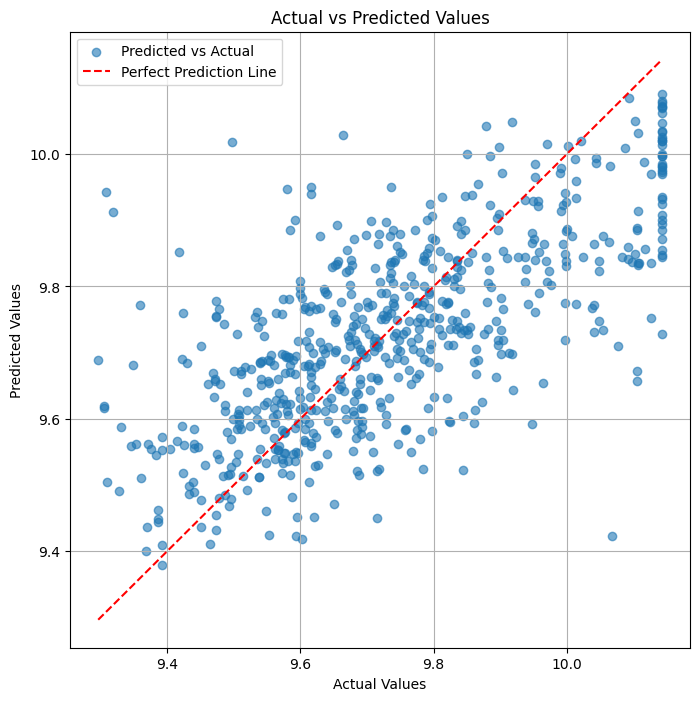

In [12]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Predicted vs Actual')

# Add the diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')

# Chart details
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

Perform hypeparameter tuning on Random Forest Regressor using GridSearchCV

In [13]:
# Define Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [14]:
# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print(f"Best R² score from Grid Search: {grid_search.best_score_:.4f}")

Best parameters: {'max_depth': None, 'n_estimators': 300}
Best R² score from Grid Search: 0.6177


In [15]:
# Check training time for  best estimator
best_rf = grid_search.best_estimator_
start = time.time()
best_rf.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.4f}s")


Training time: 4.1184s


In [16]:
# Use the best estimator on the test set
start = time.time()
y_pred = best_rf.predict(X_test)
end = time.time()
print(f"Prediction time: {end - start:.4f}s")
test_r2 = r2_score(y_test, y_pred)
print(f"Test R² score: {test_r2:.4f}")

Prediction time: 0.0766s
Test R² score: 0.6314


In [17]:
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.0886


In [18]:
mae_dict['mae_rf'] = test_mae

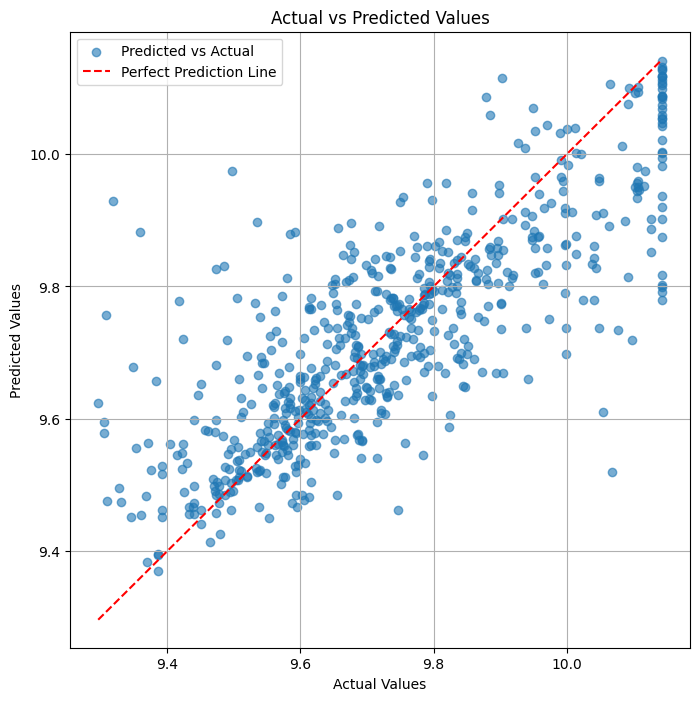

In [19]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')

# Add the diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')

# Chart details
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The chart shows much denser population compared to Linear Regression model.

## XGBoost

In [20]:
# Initialize and configure the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
start = time.time()
xgb_model.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.4f}s")

# Predict on the test set
start = time.time()
y_pred = xgb_model.predict(X_test)
end = time.time()
print(f"Prediction time: {end - start:.4f}s")

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Training time: 0.3010s
Prediction time: 0.0104s
R² Score: 0.6259
Mean Absolute Error (MAE): 0.0898


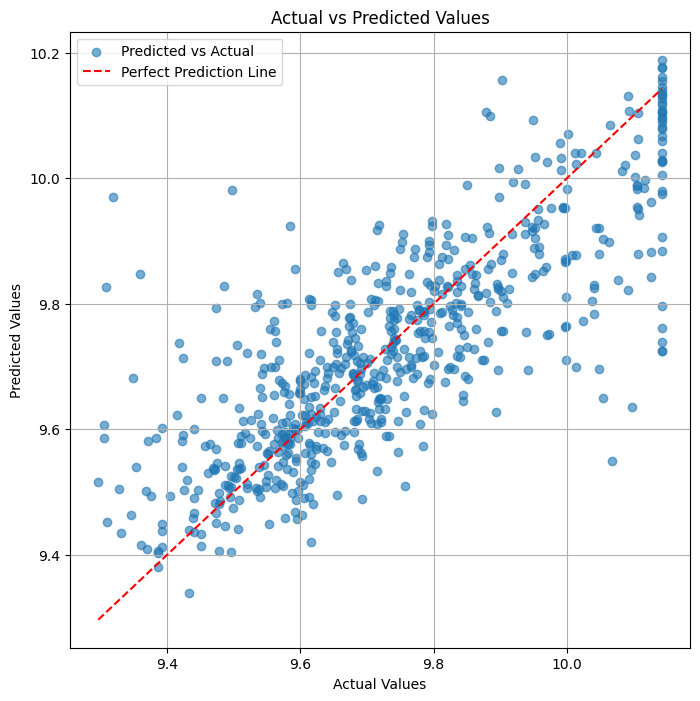

In [21]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')

# Add the diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')

# Chart details
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
mae_dict['mae_xgb'] = mae

## Compare all 3 models

Draw bar chart representing test MAE

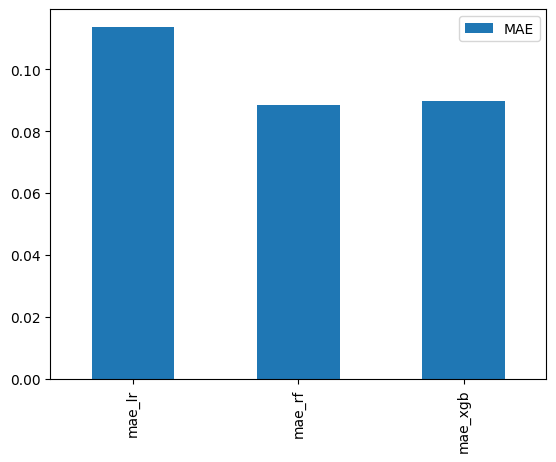

In [23]:
pd.DataFrame(mae_dict, index=['MAE']).T.plot(kind='bar');

Random Forest and XGBoost have a very similar values of R2-score and MAE, but XGBoost has a significantly smaller processing time (around 10 times less for prediction). XGBoost will be used as the dedicated model.

In [24]:
# Save model
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)